# Accounts Receivables Collection Efficacy

_Imperial College Data Science Society Challenge_

_October 2018_

_By: Andrea Lianto_

---

## Abstract
Companies are increasingly worried about if and when their customers will pay their bills. Our objective is to use the customer payment behaviour data to build a model that can predict the payment speed of a newly-created invoice.

Through the use of supervised machine learning model, specifically logistic regression in this workbook, we can estimate with a decent level of accuracy which invoices will be paid on-time, which ones will be settled late and how late these invoices will be. By analysing the coefficients of the logistic regression model, we also learn that history of late payments could be a strong predictor of a customer's payment speed. Finally, having identified the important features to predict late payments, we conclude with several recommendations for the company.

---

## Dataset

Our dataset includes the following information:
* **countryCode** - country where customer is located
* **customerID**
* **PaperlessDate** - date when customer switched from paper to electronic invoice
* **invoiceNumber**
* **InvoiceDate** - date when invoice is issued
* **DueDate** - date when invoice is due
* **InvoiceAmount** - invoice amount that needs to be settled
* **Disputed** - whether the corresponding invoice is disputed by the customer
* **SettledDate** - date when customer settled his/her invoice
* **PaperlessBill** - type of invoice sent to (paper or electronic)
* **DaysToSettle** - # of days the customer took to settle his/her invoice (i.e. SettledDate - InvoiceDate)
* **DaysLate** - # of days late (i.e. max{SettledDate - DueDate, 0})

As the data includes the number of days late, this problem is a **supervised classification machine learning task**.

## Importing Libraries

In [1]:
from datetime import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Reading Data

In [2]:
df_all = pd.read_csv('dataset.csv')
print('The data has', df_all.shape[0], 'observations and', df_all.shape[1], 'features.')
df_all.head()

The data has 2466 observations and 12 features.


,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


Note that _invoiceNumber_ is invoice-specific and can be removed later. Furthermore, features such as _SettledDate_, _DaysToSettle_ and _DaysLate_ cannot possibly be known when a new invoice is just created. We can use these to engineer additional features, but they will need to be removed from our dataset later on.

## Basic Pre-Processing

### 1. Check Missing Values

In [3]:
df_all.isnull().sum()

countryCode      0
customerID       0
PaperlessDate    0
invoiceNumber    0
InvoiceDate      0
DueDate          0
InvoiceAmount    0
Disputed         0
SettledDate      0
PaperlessBill    0
DaysToSettle     0
DaysLate         0
dtype: int64

There is no missing values in the dataset, so we don't need to worry about imputation.

### 2. Fix Data Types

In [4]:
# Convert all date columns from string to datetime format
df_all[['PaperlessDate', 'InvoiceDate', 'SettledDate', 'DueDate']] = \
    df_all[['PaperlessDate', 'InvoiceDate', 'SettledDate', 'DueDate']].apply(pd.to_datetime, errors='coerce')

In [5]:
# Replace categorical values with numerical values
df_all['Disputed'] = df_all['Disputed'].map({'Yes': 1, 'No': 0})
df_all['PaperlessBill'] = df_all['PaperlessBill'].map({'Electronic': 1, 'Paper': 0})

In [6]:
df_all.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,0,2013-01-15,0,13,0
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,1,2013-03-03,1,36,6
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,0,2013-07-08,1,5,0
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,0,2013-03-17,1,35,5
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,1,2012-11-28,0,34,4


## Data Exploration

### 1. Date Range

In [7]:
print('Invoice Date ranges from:', df_all['InvoiceDate'].min(), 'to', df_all['InvoiceDate'].max())
print('Settled Date ranges from:', df_all['SettledDate'].min(), 'to', df_all['SettledDate'].max())

Invoice Date ranges from: 2012-01-03 00:00:00 to 2013-12-02 00:00:00
Settled Date ranges from: 2012-01-13 00:00:00 to 2014-01-09 00:00:00


### 2. Characteristics of Customers

In [8]:
# Count number of unique customers
df_all['customerID'].nunique()

100

In [9]:
print(df_all['customerID'].value_counts().head())
print('\n')
print(df_all['customerID'].value_counts().tail())

9149-MATVB    36
8887-NCUZC    35
4640-FGEJI    35
9286-VLKMI    34
0688-XNJRO    34
Name: customerID, dtype: int64


7245-CKNCN    17
4632-QZOKX    17
3676-CQAIF    17
0187-ERLSR    16
2621-XCLEH    15
Name: customerID, dtype: int64


The dataset covers invoices created between 3 Jan 2012 and 2 Dec 2013 by 100 customers. Each customer had between 15 to 36 transactions with the company. This means that out of the 2,466 observations in the dataset, only 100 (4%) invoices were created by first-time customers. The rest were created by returning customers.

This is good news. With information such as Settled Date and Days Late available for us, we can easily create additional features for these returning customers to learn about their payment behaviours in the past. From a business owner's perspective, it makes sense to do so - a customer's payment history can tell a lot about his/her payment behaviour.

On the other hand, the dataset contains limited information about first-time customers. We have potentially useful features to predict the behaviour of first-time customers, such as country, invoice amount, dispute status, and invoice type. However, without demographic features (e.g. income level, household size, etc) and larger sample size, it is unlikely that a model can predict the behaviour of first-time customers with acceptable level of accuracy. As such, we should focus on working on predictive models for returning customers only.

### 3. How late were the late invoices?

In [10]:
print('There are', len(df_all[df_all['DaysLate']==0]), 'on-time invoices.\n')

# Statistical summary of Days Late for late invoices
print(df_all[df_all['DaysLate']>0]['DaysLate'].describe())

There are 1589 on-time invoices.

count    877.000000
mean       9.679590
std        7.135109
min        1.000000
25%        4.000000
50%        8.000000
75%       14.000000
max       45.000000
Name: DaysLate, dtype: float64


Majority of invoices (64%) in the dataset were settled on time. Number of days late ranged between 1 to 45 days for late invoices.

For this problem, a multi-class classification is better than a binary one ("Late" or "Not Late"). Predicting how fast late invoices will be settled can help a company prioritise. For example, an invoice that is only a few days late might not be as critical as one that is more than 1 week late. In this case, a company might want to allocate its resources to collect critical invoices instead of worrying about the non-critical ones.

As such, let's classify the invoices as follows:
* On-time (_DaysLate_ = 0)
* 1-7 days late
* 7+ days late
___

## Redefine Problem

### Objective
To use the customer payment behaviour data to build a model that can predict whether a _**returning customer**_ will pay their _newly-created bill_ on time, and if not, how fast the bill will be paid.

### Features to be used in the model
#### Invoice-level features (available in the dataset):
1. **countryCode** - country where customer is located
2. **InvoiceAmount** - invoice amount that needs to be settled
3. **Disputed** - whether the corresponding invoice is disputed by the customer
4. **PaperlessBill** - type of invoice sent to (paper or electronic)

#### Payment history features (to be engineered):
5. **PaidInv** - # of paid invoices by the same customer prior to the creation of new invoice
6. **LateInv** - # of late invoices by the same customer prior to the creation of new invoice
7. **RatioLateInv** - **LateInv** / **PaidInv**
8. **PaidAmount** - sum of paid invoice amount by the same customer prior to the creation of new invoice
9. **LateAmount** - sum of late invoice amount by the same customer prior to the creation of new invoice
10. **RatioLateAmount** - **LateAmount** / **PaidAmount**
11. **AvgDaysLate** - average number of days late for late inovices by the same customer prior to the creation of new invoice
12. **OutInv** - # of outstanding invoices by the same customer at the time of creation of new invoice
13. **LateOutInv** - # of outstanding invoices that are already late by the same customer at the time of creation of new invoice
14. **RatioLateOutInv** - **LateOutInv** / **OutInv**
15. **OutAmount** - sum of outstanding invoice amount by the same customer at the time of creation of new invoice
16. **LateOutAmount** - sum of late outstanding invoice amount by the same customer at the time of creation of new invoice
17. **RatioLateOutAmount**  - **LateOutAmount** / **OutAmount**

### Target
* **HowLate** - on-time (0), 1-7 days late (1), 7+ days late (2)

### Assumptions:
* The model predicts how fast a bill is paid given **no intervention** by the company
* No more first-time customers. The company only serve the 100 returning customers in the dataset.
___

## Feature Engineering

### 1. Paid Invoices, Late Invoices, and their ratio

In [11]:
# Function to get all paid invoices by the same customer prior to date
def get_paid_invoices(customerID, date):
    return (df_all[(df_all['customerID'] == customerID) & (df_all['SettledDate'] <= date)])

# Function to get all late invoices by the same customer prior to date
def get_late_invoices(customerID, date):
    paid_invoices = get_paid_invoices(customerID, date)
    return paid_invoices[paid_invoices['DaysLate'] > 0]

In [12]:
invoice_history = {'PaidInv':[], 'LateInv':[]}

for i in df_all.index:
    date = df_all.loc[i,'InvoiceDate']
    customerID = df_all.loc[i, 'customerID']
    invoice_history['PaidInv'].append(len(get_paid_invoices(customerID, date)))
    invoice_history['LateInv'].append(len(get_late_invoices(customerID, date)))

invoice_history = pd.DataFrame.from_dict(invoice_history)

df_all = pd.concat([df_all, invoice_history], axis = 1)

# Calculate ratio of late invoices to paid invoices
df_all['RatioLateInv'] = df_all['LateInv'] / df_all['PaidInv']
df_all['RatioLateInv'].fillna(0, inplace=True)
df_all.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,PaidInv,LateInv,RatioLateInv
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,0,2013-01-15,0,13,0,9,1,0.111111
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,1,2013-03-03,1,36,6,13,1,0.076923
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,0,2013-07-08,1,5,0,20,0,0.000000
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,0,2013-03-17,1,35,5,6,6,1.000000
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,1,2012-11-28,0,34,4,7,1,0.142857


### 2. Amount of Paid Invoices, Amount of Late Invoices, and their ratio

In [13]:
invoice_amount = {'PaidAmount':[], 'LateAmount':[]}

for i in df_all.index:
    date = df_all.loc[i,'InvoiceDate']
    customerID = df_all.loc[i, 'customerID']
    invoice_amount['PaidAmount'].append(get_paid_invoices(customerID, date)['InvoiceAmount'].sum())
    invoice_amount['LateAmount'].append(get_late_invoices(customerID, date)['InvoiceAmount'].sum())

invoice_amount = pd.DataFrame.from_dict(invoice_amount)

df_all = pd.concat([df_all, invoice_amount], axis = 1)

# Calculate ratio of late invoice amount to paid invoice amount
df_all['RatioLateAmount'] = df_all['LateAmount'] / df_all['PaidAmount']
df_all['RatioLateAmount'].fillna(0, inplace=True)
df_all.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,PaidInv,LateInv,RatioLateInv,PaidAmount,LateAmount,RatioLateAmount
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,0,2013-01-15,0,13,0,9,1,0.111111,545.25,48.65,0.089225
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,1,2013-03-03,1,36,6,13,1,0.076923,865.71,57.55,0.066477
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,0,2013-07-08,1,5,0,20,0,0.000000,1466.70,0.00,0.000000
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,0,2013-03-17,1,35,5,6,6,1.000000,535.43,535.43,1.000000
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,1,2012-11-28,0,34,4,7,1,0.142857,402.39,58.64,0.145729


### 3. Average Days Late

In [14]:
days_late = {'AvgDaysLate':[]}

for i in df_all.index:
    date = df_all.loc[i,'InvoiceDate']
    customerID = df_all.loc[i, 'customerID']
    days_late['AvgDaysLate'].append(get_late_invoices(customerID, date)['DaysLate'].mean())

days_late = pd.DataFrame.from_dict(days_late)

df_all = pd.concat([df_all, days_late], axis = 1)
df_all['AvgDaysLate'].fillna(0, inplace=True)

df_all.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,PaidInv,LateInv,RatioLateInv,PaidAmount,LateAmount,RatioLateAmount,AvgDaysLate
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,0,2013-01-15,0,13,0,9,1,0.111111,545.25,48.65,0.089225,17.000000
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,1,2013-03-03,1,36,6,13,1,0.076923,865.71,57.55,0.066477,1.000000
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,0,2013-07-08,1,5,0,20,0,0.000000,1466.70,0.00,0.000000,0.000000
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,0,2013-03-17,1,35,5,6,6,1.000000,535.43,535.43,1.000000,9.833333
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,1,2012-11-28,0,34,4,7,1,0.142857,402.39,58.64,0.145729,6.000000


### 4. Outstanding Invoices, Late Outstanding Invoices and their ratio

In [15]:
# Function to get all outstanding invoices by the same customer as of date
def get_outstanding_invoices(customerID, date):
    return (df_all[(df_all['customerID'] == customerID) & (df_all['InvoiceDate'] < date) & \
                   ((df_all['SettledDate'] > date) | (df_all['SettledDate'].isnull()))])

# Function to get all late invoices by the same customer prior to date
def get_late_outstanding_invoices(customerID, date):
    outstanding_invoices = get_outstanding_invoices(customerID, date)
    return outstanding_invoices[outstanding_invoices['DueDate'] < date]

In [16]:
outstanding_invoices = {'OutInv':[], 'LateOutInv':[]}

for i in df_all.index:
    date = df_all.loc[i,'InvoiceDate']
    customerID = df_all.loc[i, 'customerID']
    outstanding_invoices['OutInv'].append(len(get_outstanding_invoices(customerID, date)))
    outstanding_invoices['LateOutInv'].append(len(get_late_outstanding_invoices(customerID, date)))

outstanding_invoices = pd.DataFrame.from_dict(outstanding_invoices)

df_all = pd.concat([df_all, outstanding_invoices], axis = 1)

# Calculate ratio of late invoice amount to paid invoice amount
df_all['RatioLateOutInv'] = df_all['LateOutInv'] / df_all['OutInv']
df_all['RatioLateOutInv'].fillna(0, inplace=True)
df_all.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,...,PaidInv,LateInv,RatioLateInv,PaidAmount,LateAmount,RatioLateAmount,AvgDaysLate,OutInv,LateOutInv,RatioLateOutInv
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,0,2013-01-15,0,...,9,1,0.111111,545.25,48.65,0.089225,17.000000,0,0,0.0
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,1,2013-03-03,1,...,13,1,0.076923,865.71,57.55,0.066477,1.000000,1,0,0.0
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,0,2013-07-08,1,...,20,0,0.000000,1466.70,0.00,0.000000,0.000000,0,0,0.0
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,0,2013-03-17,1,...,6,6,1.000000,535.43,535.43,1.000000,9.833333,1,1,1.0
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,1,2012-11-28,0,...,7,1,0.142857,402.39,58.64,0.145729,6.000000,0,0,0.0


### 5. Amount of Outstanding Invoices, Amount of Late Outstanding Invoices, and their ratio

In [17]:
outstanding_amount = {'OutAmount':[], 'LateOutAmount':[]}

for i in df_all.index:
    date = df_all.loc[i,'InvoiceDate']
    customerID = df_all.loc[i, 'customerID']
    outstanding_amount['OutAmount'].append(get_outstanding_invoices(customerID, date)['InvoiceAmount'].sum())
    outstanding_amount['LateOutAmount'].append(get_late_outstanding_invoices(customerID, date)['InvoiceAmount'].sum())

outstanding_amount = pd.DataFrame.from_dict(outstanding_amount)

df_all = pd.concat([df_all, outstanding_amount], axis = 1)

# Calculate ratio of late invoice amount to paid invoice amount
df_all['RatioLateOutAmount'] = df_all['LateOutAmount'] / df_all['OutAmount']
df_all['RatioLateOutAmount'].fillna(0, inplace=True)
df_all.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,...,PaidAmount,LateAmount,RatioLateAmount,AvgDaysLate,OutInv,LateOutInv,RatioLateOutInv,OutAmount,LateOutAmount,RatioLateOutAmount
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,0,2013-01-15,0,...,545.25,48.65,0.089225,17.000000,0,0,0.0,0.00,0.00,0.0
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,1,2013-03-03,1,...,865.71,57.55,0.066477,1.000000,1,0,0.0,84.87,0.00,0.0
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,0,2013-07-08,1,...,1466.70,0.00,0.000000,0.000000,0,0,0.0,0.00,0.00,0.0
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,0,2013-03-17,1,...,535.43,535.43,1.000000,9.833333,1,1,1.0,89.98,89.98,1.0
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,1,2012-11-28,0,...,402.39,58.64,0.145729,6.000000,0,0,0.0,0.00,0.00,0.0


### 6. Target: HowLate

In [18]:
# df_all['HowLate'] = df_all['DaysLate'].apply(lambda x: 3 if x > 14 else(2 if x > 7 else(1 if x > 0 else 0)))
df_all['HowLate'] = df_all['DaysLate'].apply(lambda x: 2 if x > 7 else(1 if x > 0 else 0))
df_all.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,...,LateAmount,RatioLateAmount,AvgDaysLate,OutInv,LateOutInv,RatioLateOutInv,OutAmount,LateOutAmount,RatioLateOutAmount,HowLate
0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,2013-02-01,55.94,0,2013-01-15,0,...,48.65,0.089225,17.000000,0,0,0.0,0.00,0.00,0.0,0
1,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,2013-02-25,61.74,1,2013-03-03,1,...,57.55,0.066477,1.000000,1,0,0.0,84.87,0.00,0.0,1
2,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,2013-08-02,65.88,0,2013-07-08,1,...,0.00,0.000000,0.000000,0,0,0.0,0.00,0.00,0.0,0
3,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,2013-03-12,105.92,0,2013-03-17,1,...,535.43,1.000000,9.833333,1,1,1.0,89.98,89.98,1.0,1
4,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,2012-11-24,72.27,1,2012-11-28,0,...,58.64,0.145729,6.000000,0,0,0.0,0.00,0.00,0.0,1


## Removing First-Time Customers

In [19]:
# Remove invoices by first-time customers
df = df_all.drop(df_all[(df_all.PaidInv == 0) & (df_all.OutInv == 0)].index)

## Correlations and Relationships

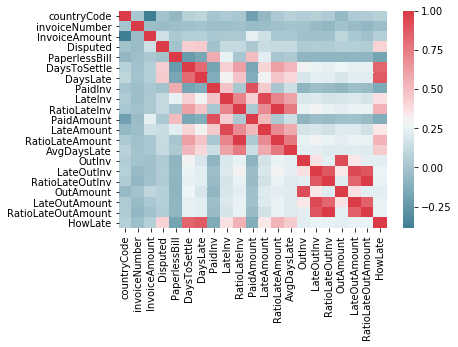

In [20]:
# Correlation heat map
correlations = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlations, cmap = cmap)

In [21]:
# Find all correlations with target
df.corr()['HowLate'].sort_values()

PaperlessBill        -0.179934
PaidInv              -0.141912
PaidAmount           -0.128556
invoiceNumber        -0.028796
InvoiceAmount         0.060061
countryCode           0.065113
OutInv                0.231138
OutAmount             0.231393
LateOutAmount         0.251489
RatioLateOutAmount    0.255418
RatioLateOutInv       0.255571
LateOutInv            0.265513
LateAmount            0.347941
LateInv               0.369012
Disputed              0.424158
AvgDaysLate           0.447806
RatioLateAmount       0.543996
RatioLateInv          0.544984
DaysToSettle          0.838645
DaysLate              0.878897
HowLate               1.000000
Name: HowLate, dtype: float64

There are several moderately strong positive correlations between our target (_HowLate_) and features such as _RatioLateInv, RatioLateAmount, Disputed_ and _AvgDaysLate_. Intuitively, the correlations make sense. The worse one's payment behaviour was in the past, the more likely that he/she pays late.

Nonetheless, multicollinearity is also observed among our engineered features, for example between _RatioLateInv_ and _RatioLateAmount_. This is expected as both features concern the same set of late invoices by a particular customer. We must be careful when deciding which of these features to include in our model.

Next, let's look at how categorical features (country, type of bill, and dispute status) are related to our target variable.

### 1.  Country

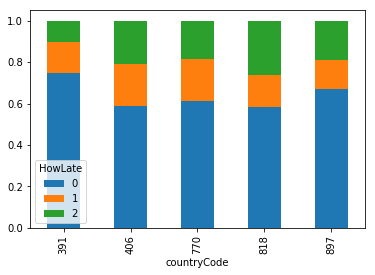

In [22]:
# Find the proportion of HowLate classes by country
country = df.pivot_table(values='InvoiceAmount', index = 'countryCode', columns = 'HowLate', aggfunc = np.count_nonzero)
country = country.div(country.sum(1), axis = 0)
country.plot(kind='bar', stacked=True)

Country 391 has the highest proportion of on-time invoice payments, while countries 406 and 818 perform the worst. The relationship between country and how late an invoice is settled doesn't seem to be strong, but there is a slight difference between some countries. So, we'll keep _countryCode_ in our model for now.

### 2.  Type of Bill

Text(0.5,0,'Type of Bill (Paper: 0, Electronic: 1)')

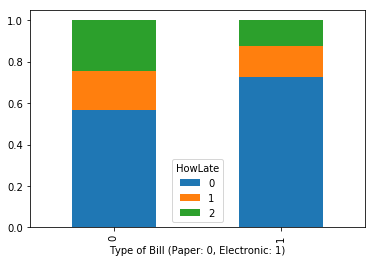

In [23]:
bill = df.pivot_table(values='InvoiceAmount', index = 'PaperlessBill', columns = 'HowLate', aggfunc = np.count_nonzero)
bill = bill.div(bill.sum(1), axis = 0)
bill.plot(kind='bar', stacked=True)
plt.xlabel('Type of Bill (Paper: 0, Electronic: 1)')

Electronic invoices seem to be settled faster than paper ones.

### 3. Dispute Status

Text(0.5,0,'Disputed Status')

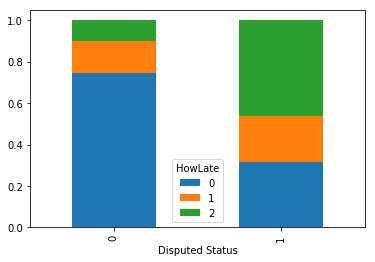

In [24]:
dispute = df.pivot_table(values='InvoiceAmount', index = 'Disputed', columns = 'HowLate', aggfunc = np.count_nonzero)
dispute = dispute.div(dispute.sum(1), axis = 0)
dispute.plot(kind='bar', stacked=True)
plt.xlabel('Disputed Status')

Clearly, disputed invoices are settled later than non-disputed ones. The relationship seems to be strong and indeed, we have seen that _Disputed_ is among the top features with strong correlation with _HowLate_.
___

## More Feature Engineering...

### 1. One-Hot Encoding for countryCode

In [25]:
country_encoding = pd.get_dummies(df['countryCode'],  prefix='country')
df = pd.concat([country_encoding, df], axis = 1)
df.head()

,country_391,country_406,country_770,country_818,country_897,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,...,LateAmount,RatioLateAmount,AvgDaysLate,OutInv,LateOutInv,RatioLateOutInv,OutAmount,LateOutAmount,RatioLateOutAmount,HowLate
0,1,0,0,0,0,391,0379-NEVHP,2013-04-06,611365,2013-01-02,...,48.65,0.089225,17.000000,0,0,0.0,0.00,0.00,0.0,0
1,0,1,0,0,0,406,8976-AMJEO,2012-03-03,7900770,2013-01-26,...,57.55,0.066477,1.000000,1,0,0.0,84.87,0.00,0.0,1
2,1,0,0,0,0,391,2820-XGXSB,2012-01-26,9231909,2013-07-03,...,0.00,0.000000,0.000000,0,0,0.0,0.00,0.00,0.0,0
3,0,1,0,0,0,406,9322-YCTQO,2012-04-06,9888306,2013-02-10,...,535.43,1.000000,9.833333,1,1,1.0,89.98,89.98,1.0,1
4,0,0,0,1,0,818,6627-ELFBK,2012-11-26,15752855,2012-10-25,...,58.64,0.145729,6.000000,0,0,0.0,0.00,0.00,0.0,1


### 2. Removing Unnecessary Columns

In [26]:
df = df.drop(['countryCode', 'customerID', 'PaperlessDate', 'invoiceNumber', 'InvoiceDate', 'DueDate', \
         'SettledDate', 'DaysToSettle', 'DaysLate'], axis=1)

df.head()

,country_391,country_406,country_770,country_818,country_897,InvoiceAmount,Disputed,PaperlessBill,PaidInv,LateInv,...,LateAmount,RatioLateAmount,AvgDaysLate,OutInv,LateOutInv,RatioLateOutInv,OutAmount,LateOutAmount,RatioLateOutAmount,HowLate
0,1,0,0,0,0,55.94,0,0,9,1,...,48.65,0.089225,17.000000,0,0,0.0,0.00,0.00,0.0,0
1,0,1,0,0,0,61.74,1,1,13,1,...,57.55,0.066477,1.000000,1,0,0.0,84.87,0.00,0.0,1
2,1,0,0,0,0,65.88,0,1,20,0,...,0.00,0.000000,0.000000,0,0,0.0,0.00,0.00,0.0,0
3,0,1,0,0,0,105.92,0,1,6,6,...,535.43,1.000000,9.833333,1,1,1.0,89.98,89.98,1.0,1
4,0,0,0,1,0,72.27,1,0,7,1,...,58.64,0.145729,6.000000,0,0,0.0,0.00,0.00,0.0,1


## Feature Selection

As observed above, we have collinear features. Ideally, only one from each pair of collinear features is included in the model.

We'll remove collinear features using the code below, which is adapted from a [Stack Overflow comment](https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on/43104383#43104383).

In [27]:
def remove_collinear_features(x, threshold):
    
    # Dont want to remove correlations between HowLate
    y = x['HowLate']
    x = x.drop(columns = ['HowLate'])
    
    # Set of all the names of deleted columns
    col_corr = set() 
    corr_matrix = x.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in x.columns:
                    del x[colname] # deleting the column from the dataset
    
    x['HowLate'] = y
    return x

In [28]:
selected_features = remove_collinear_features(df, 0.6);
selected_features.shape

(2366, 13)

---
## Split into Training and Testing Set

In [29]:
from sklearn.model_selection import train_test_split

# Separate out the features and targets
targets = pd.DataFrame(selected_features['HowLate'])
features = selected_features.drop(columns='HowLate')

# Split into 50% training and 50% testing set
df_features_train, df_features_test, df_targets_train, df_targets_test = \
    train_test_split(features, targets, test_size = 0.5, random_state = 42)

print("Training features size:", df_features_train.shape)
print("Training targets size:", df_targets_train.shape)
print("Testing features size:", df_features_test.shape)
print("Testing targets size:", df_targets_test.shape)

Training features size: (1183, 12)
Training targets size: (1183, 1)
Testing features size: (1183, 12)
Testing targets size: (1183, 1)


## Feature Scaling

Features related to invoice amount are by nature much larger in value compared to other features. Hence, we need to take care of this by scaling our features.

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(df_features_train)

# Transform both the training and testing data
features_train = scaler.transform(df_features_train)
features_test = scaler.transform(df_features_test)

In [31]:
# Convert targets data frames to one-dimensional array (vector)
targets_train = np.array(df_targets_train).reshape((-1, ))
targets_test = np.array(df_targets_test).reshape((-1, ))

## Evaluating Machine Learning Models

The customer payment behaviour dataset is relatively small, so parametric models might be more suitable as they don't need as many data points to generalise well. Nonetheless, we will also run non-parametric models to see if our conjecture was right. The models that we will evaluate are:
1. Baseline (Majority Class Predictor)
2. Logistic Regression
3. Naïve Bayes
4. Decision Tree Classifier
5. Support Vector Machine
6. Gradient Boosting Classifier
7. Random Forest Classifier

For now, we'll run all these models using scikit-learn's default settings.

### Importing Scikit-Learn Libraries

In [32]:
from sklearn.preprocessing import label_binarize

from sklearn.multiclass import OneVsRestClassifier

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix

### Metric: AUC (Area under the ROC curve)
We will use AUC, or area under the ROC (Receiver Operating Characteristics) curve, as a comparison metric between different models. ROC curve is a probability curve that represents the trade-off between true positive rate and false positive rate for all possible threshold values in a model, and so AUC measures how well the model can distinguish between classes.

Since our problem involves a 3-class classification, we will need to binarize our labels and use the One-Vs-Rest Classifier available in the scikit-learn library to evaluate the AUC of our model. The code below is adapted from: [ROC curve for multiclass classification](https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification).

In [33]:
# Function to generate ROC curves and weighted AUC for multiclass classification
def compute_auc_roc_multiclass(Y_true, Y_pred_score, n_classes, weightage):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], Y_pred_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print('AUC of class {} is {}'.format(i, round(roc_auc[i], 3)))
    
    weighted_auc = sum(weightage[k]*roc_auc[k] for k in range(n_classes)) / sum(weightage)
    print('Weighted AUC is', round(weighted_auc,3))
    
    return weighted_auc
    
    # Plot of a ROC curve for a specific class
#     for i in range(n_classes):
#         plt.figure()
#         plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver operating characteristic example')
#         plt.legend(loc="lower right")

#     plt.show()

# Function to fit and evaluate multiclass classifier
def fit_and_evaluate_multiclass(model, X_train, Y_train, X_test, Y_test, n_classes, weightage):
    
    # Classifier
    clf = OneVsRestClassifier(model)
    
    # Compute probability score of prediction
    try:
        pred_score = clf.fit(X_train, Y_train).predict_proba(X_test)
    except:
        pred_score = clf.fit(X_train, Y_train).decision_function(X_test)
    
    # Compute performance metric
    weighted_auc = compute_auc_roc_multiclass(Y_test, pred_score, n_classes, weightage)

    return weighted_auc

In [34]:
# Binarize labels
targets_test_bin = label_binarize(targets_test, classes=[0,1,2])
targets_train_bin = label_binarize(targets_train, classes=[0,1,2])
n_classes = 3

# Assume equal weightage for all classes, i.e. identifying on-time and late payments are equally important
# Weightage may be adjusted accordingly if identifying late payments is of top priority
weightage = [1,1,1]

### 1. Baseline: Majority Class Predictor

As a baseline model, intuitively, we can select the class with the highest number of observations in the training set and use that as our best guess in the testing set. The bulk of invoices in the training set were paid on-time, so $0$ is our best guess for all invoices in the testing set.

In [35]:
baseline_pred = np.zeros(len(targets_test), dtype=int)
baseline_pred_score_bin = label_binarize(baseline_pred, classes = [0,1,2])
baseline_auc = compute_auc_roc_multiclass(targets_test_bin, baseline_pred_score_bin, n_classes, weightage)

AUC of class 0 is 0.5
AUC of class 1 is 0.5
AUC of class 2 is 0.5
Weighted AUC is 0.5


### 2. Logistic Regression

In [36]:
print("Logistic regression:")
lr_auc = fit_and_evaluate_multiclass(LogisticRegression(), features_train, targets_train_bin,\
                                           features_test, targets_test_bin, n_classes, weightage)

Logistic regression:
AUC of class 0 is 0.886
AUC of class 1 is 0.701
AUC of class 2 is 0.892
Weighted AUC is 0.826


### 3. Naïve Bayes

In [37]:
print("Naïve Bayes:")
naive_bayes_auc = fit_and_evaluate_multiclass(GaussianNB(), features_train, targets_train_bin,\
                                               features_test, targets_test_bin, n_classes, weightage)

Naïve Bayes:
AUC of class 0 is 0.815
AUC of class 1 is 0.651
AUC of class 2 is 0.812
Weighted AUC is 0.759


### 4. Decision Tree

In [38]:
print("Decision tree classifier:")
decision_tree_auc = fit_and_evaluate_multiclass(DecisionTreeClassifier(), features_train, targets_train_bin,\
                                                   features_test, targets_test_bin, n_classes, weightage)

Decision tree classifier:
AUC of class 0 is 0.713
AUC of class 1 is 0.561
AUC of class 2 is 0.71
Weighted AUC is 0.662


### 5. Support Vector Machine

In [39]:
print("Support Vector Machine:")
svm_auc = fit_and_evaluate_multiclass(LinearSVC(), features_train, targets_train_bin,\
                                       features_test, targets_test_bin, n_classes, weightage)

Support Vector Machine:
AUC of class 0 is 0.89
AUC of class 1 is 0.71
AUC of class 2 is 0.9
Weighted AUC is 0.833


### 6. Gradient Boosting

In [40]:
print("Gradient Boosting Classifier")
gradient_boosting_auc = fit_and_evaluate_multiclass(GradientBoostingClassifier(), features_train, targets_train_bin,\
                                                       features_test, targets_test_bin, n_classes, weightage)

Gradient Boosting Classifier
AUC of class 0 is 0.898
AUC of class 1 is 0.725
AUC of class 2 is 0.902
Weighted AUC is 0.842


### 7. Random Forest

In [43]:
print("Random Forest Classifier")
random_forest_auc = fit_and_evaluate_multiclass(RandomForestClassifier(), features_train, targets_train_bin,\
                                                   features_test, targets_test_bin, n_classes, weightage)

Random Forest Classifier
AUC of class 0 is 0.857
AUC of class 1 is 0.698
AUC of class 2 is 0.853
Weighted AUC is 0.803


### Comparing AUC of different models

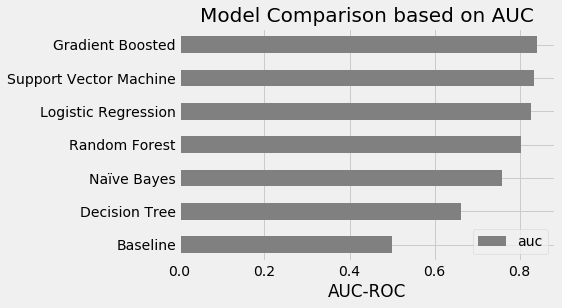

In [44]:
plt.style.use('fivethirtyeight')

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Baseline', 'Logistic Regression', 'Naïve Bayes', 
                                           'Decision Tree', 'Support Vector Machine',
                                           'Gradient Boosted', 'Random Forest'],
                                 'auc': [baseline_auc, lr_auc, naive_bayes_auc,
                                         decision_tree_auc, svm_auc, 
                                         gradient_boosting_auc, random_forest_auc]})

# Horizontal bar chart of test mae
model_comparison.sort_values('auc').plot(x = 'model', y = 'auc', kind = 'barh', color = 'grey')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('AUC-ROC'); plt.xticks(size = 14)
plt.title('Model Comparison based on AUC', size = 20);

Despite our small dataset, non-parametric classifiers such as gradient boosting classifier, support vector machine, and random forest seem to perform well, with AUC of 0.801 to 0.841. Among the parametric classifiers, logistic regression is the most robust, scoring an AUC of 0.826.

Since the improvement in AUC is not that significant when using gradient boosting and support vector machine, we'll work on optimizing **logistic regression** as our final model. Logistic regression has a probabilistic output and easily interpretable feature coefficients, which can be useful for evaluating feature importances and for providing recommendations to the company.

## Optimizing Model - Grid Search with Cross Validation

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
### Hyperparameter Tuning

# Regularization parameter
C = [0.01, 0.1, 1, 10, 100]

# Whether intercept should added to the decision function
fit_intercept = [True, False]

# Class weight
class_weight = [None, 'balanced']

# Choice of solver
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Define the grid of hyperparameters to search
hyperparameter_grid = {'C': C,
                       'fit_intercept': fit_intercept,
                       'class_weight': class_weight,
                       'solver': solver}

In [47]:
# Create the model to use for hyperparameter tuning
model = LogisticRegression(random_state=42)

# Set up the grid search with 4-fold cross validation
gridsearch_cv = GridSearchCV(estimator=model,
                               param_grid=hyperparameter_grid,
                               cv=4, 
                               scoring = 'accuracy',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True)

In [49]:
gridsearch_cv.fit(features_train, targets_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'fit_intercept': [True, False], 'class_weight': [None, 'balanced'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [50]:
# Get all of the cv results and sort by the test performance
gridsearch_results = pd.DataFrame(gridsearch_cv.cv_results_).sort_values('mean_test_score', ascending = False)

gridsearch_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_fit_intercept,param_solver,params,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
68,0.058949,0.004907,0.000577,0.000208,10,None,False,sag,"{'C': 10, 'class_weight': None, 'fit_intercept...",0.710438,...,0.755932,0.732883,0.018888,1,0.74605,0.741826,0.740991,0.729730,0.739649,0.006040
67,0.008489,0.003567,0.000961,0.000891,10,None,False,liblinear,"{'C': 10, 'class_weight': None, 'fit_intercept...",0.710438,...,0.755932,0.732883,0.018888,1,0.74605,0.741826,0.740991,0.730856,0.739931,0.005579
66,0.038092,0.018240,0.000323,0.000021,10,None,False,lbfgs,"{'C': 10, 'class_weight': None, 'fit_intercept...",0.710438,...,0.755932,0.732883,0.018888,1,0.74605,0.741826,0.740991,0.730856,0.739931,0.005579
65,0.036432,0.010586,0.000306,0.000007,10,None,False,newton-cg,"{'C': 10, 'class_weight': None, 'fit_intercept...",0.710438,...,0.755932,0.732883,0.018888,1,0.74605,0.741826,0.740991,0.730856,0.739931,0.005579
69,0.028869,0.001382,0.000346,0.000011,10,None,False,saga,"{'C': 10, 'class_weight': None, 'fit_intercept...",0.710438,...,0.755932,0.732883,0.018888,1,0.74605,0.741826,0.740991,0.730856,0.739931,0.005579


In [51]:
initial_model = LogisticRegression()
final_model = gridsearch_cv.best_estimator_

In [52]:
print("Initial model:")
lr_auc = fit_and_evaluate_multiclass(initial_model, features_train, targets_train_bin, \
                                     features_test, targets_test_bin, n_classes, weightage)

print('\n')

print("Final model:")
best_lr_auc = fit_and_evaluate_multiclass(final_model, features_train, targets_train_bin, \
                                          features_test, targets_test_bin, n_classes, weightage)

Initial model:
AUC of class 0 is 0.886
AUC of class 1 is 0.701
AUC of class 2 is 0.892
Weighted AUC is 0.826


Final model:
AUC of class 0 is 0.891
AUC of class 1 is 0.706
AUC of class 2 is 0.9
Weighted AUC is 0.832


In [53]:
pd.DataFrame(targets_test_bin).sum()

0    768
1    204
2    211
dtype: int64

In [54]:
final_pred = final_model.fit(features_train, targets_train).predict(features_test)
pd.DataFrame(confusion_matrix(targets_test, final_pred))

,0,1,2
0,718,11,39
1,133,16,55
2,66,14,131


True positive rate is especially low for Group 1 (1-7 days late) at 7.8%. Nonetheless, the model does a a decent job identifying Group 2 (7+ days late) with true positive rate of 62.1%.

## Interpretation

In [55]:
# Extract the model coefficients into a dataframe
feature_results = pd.DataFrame({'feature': list(features.columns), 
                                'importance_group_0': final_model.coef_[0],
                                'importance_group_1': final_model.coef_[1],
                                'importance_group_2': final_model.coef_[2]})

# Sort model coefficients for group 2 (7+ days late)
feature_results = feature_results.sort_values('importance_group_2', ascending = False).reset_index(drop=True)

feature_results

,feature,importance_group_0,importance_group_1,importance_group_2
0,LateInv,-9.111229,3.651170,9.063172
1,Disputed,-2.243567,0.283267,2.202230
2,LateOutInv,-3.318252,0.688604,1.273012
3,OutInv,-1.613881,0.784055,0.921621
4,InvoiceAmount,-0.964705,0.454106,0.310915
5,PaperlessBill,0.768802,-0.030881,-0.733807
6,country_897,1.346709,-2.268833,-1.524208
7,country_818,1.760331,-2.474614,-1.598440
8,country_770,1.126938,-1.639186,-1.856394
9,country_391,1.750178,-2.071399,-1.985407


From our logistic regression model coefficients, we can deduce that _LateInv, Disputed,_ and _LateOutInv_ are strong predictors for Group 2 (7+ days late). A customer with more records of late invoices in the past and higher number late outstanding invoices is more likely to pay late. Dispute is also likely to delay an invoice payment.

_(Note: The effect of countries is unclear in this model, but removing them doesn't improve AUC score. Hence, they are still included in the final model. Workings are not shown to keep the notebook concise.)_

## Recommendations:
* Set an upper limit to invoice amount for customers with history of late invoices and those with some late outstanding invoices. Alternatively, the company could take a milder action by simply sending more frequent payment reminders to customers with a lot of late invoices in the past.
* Minimise the probability of dispute by ensuring accurate invoice details, as well as accurate and timely delivery of goods.